# SETUP

In [1]:
import pickle
import sys
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchvision.transforms as T
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import (
    confusion_matrix,  # for evaluating the model of a single pixel basis
)
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

from max import load_data, locate_data, verify_dimensions, show_imageNlabel, count_classes
from _types import RGB, CLASS_COLOR_LABELS

pd.set_option("display.max_columns", None)

DATA_DIR = Path("data/")

assert sys.version_info >= (
    3,
    10,
), "This notebook requires at least Python 3.10"

# DATA LOADING

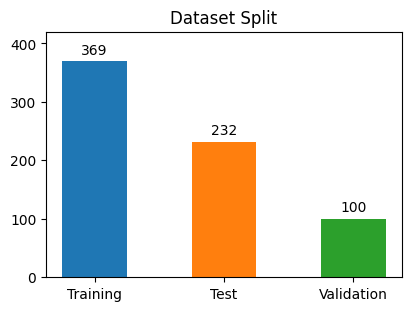

In [2]:
# Locate the data
CamVidOri_path = DATA_DIR / "CamVid"  # the data as it was downloaded

(
    X_train_paths,
    y_train_paths,
    X_test_paths,
    y_test_paths,
    X_val_paths,
    y_val_paths,
) = locate_data(CamVidOri_path, show=True)

In [3]:
# Load data into memory
X_train = load_data(X_train_paths)
y_train = load_data(y_train_paths)

# check all dimensions are consistent with the first training image
h, w, _ = X_train[0].shape
print(f"\nImage height: {h}, Image width: {w}")

print("Training images all have the dimensions above:", verify_dimensions(X_train, h, w))
print("Labeled training images all have the dimensions above:", verify_dimensions(y_train, h, w))

Loading images into memory...


100%|██████████| 369/369 [00:07<00:00, 46.46it/s]


Loading images into memory...


100%|██████████| 369/369 [00:03<00:00, 112.51it/s]



Image height: 720, Image width: 960
Training images all have the dimensions above: True
Labeled training images all have the dimensions above: True


# EDA

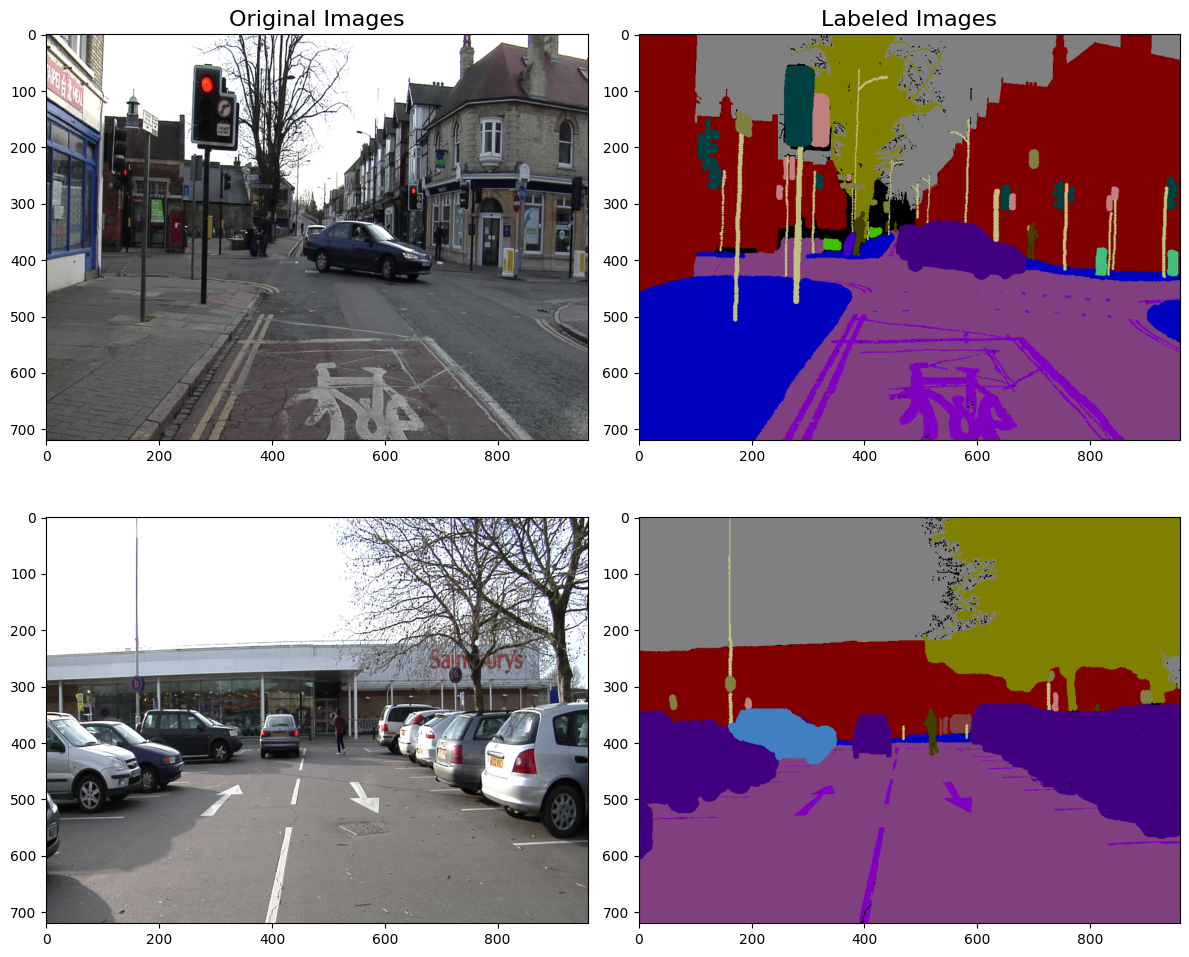

In [4]:
# randomly sampled n_images and show them with their labeled segmentation
n_images = 2
sampled_idxs = np.random.randint(0, len(X_train), n_images)
show_imageNlabel(sampled_idxs, X_train, y_train)

the training data has a total of 255_052_800 pixels


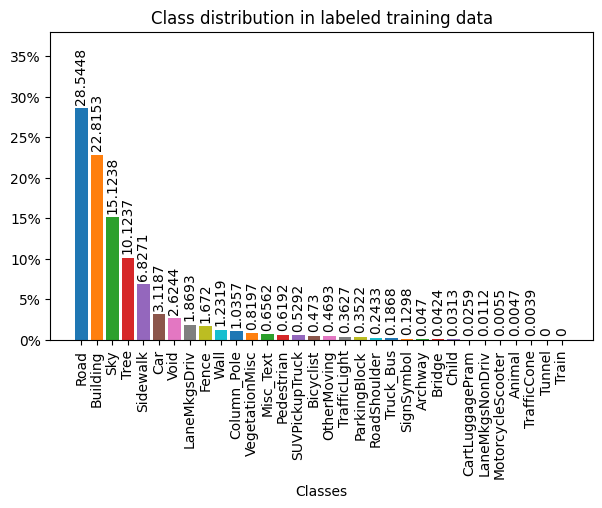

In [13]:
# Run the cell above first to compute the class counts
with open("dev_output/y_train_class_count.pkl", "rb") as f:
    class_counts = pickle.load(f)

# Compute total number of pixels in labeled training data
total_pixels = sum(class_counts.values())
print("the training data has a total of {:_} pixels".format(total_pixels))

class_counts = dict(
    sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
)  # sort by value

# Compute percentages
percentages = {}
for c, n_class in class_counts.items():
    percentages[c] = (n_class / total_pixels) * 100

# Plot class distribution
fig, ax = plt.subplots(figsize=(7, 4))
for c, p in percentages.items():
    bar = ax.bar(c, round(p, 4))
    ax.tick_params(axis="x", rotation=90)
    ax.bar_label(container=bar, padding=3, rotation=90)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))
plt.title("Class distribution in labeled training data")
plt.ylim(0, 38)
plt.xlabel("Classes")
plt.show()

# MODEL DEV

## Segmentation Evaluation Metrics

Intersection over Union (IoU) -> commonly used evaluation metric for supervised semantic image segmentation tasks.

In [13]:
SMOOTH = 1e-6 # To avoid division by zero


def iou(model_output: torch.Tensor, label: torch.Tensor) -> float:
    """Calculate the IoU for a single model output and label pair."""
    intersection = (
        (model_output & label).float().sum((1, 2))
    )  # Will be zero if Truth=0 or Prediction=0
    union = (model_output | label).float().sum((1, 2))  # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # smooth division to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.7), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch


def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.7), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

Training process:
1. calc loss
2. calc gradient
3. update weights
4. repeat